In [1]:
%load_ext line_profiler
%load_ext tensorboard

In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel(0)
tf.autograph.set_verbosity(0)
import tensorflow.compat.v1.keras.backend as backend
from tensorflow.compat.v1 import Session, ConfigProto
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.compat.v1 import GPUOptions
from matplotlib import pyplot as plt
from collections import deque
import datetime
import time
import random
from tqdm import tqdm
from PIL import Image
import cv2

In [3]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training (default=50_000)
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training (default=1_000)
MINIBATCH_SIZE = 32  # How many steps (samples) to use for training (default=32, pref multiple of 8)
UPDATE_TARGET_EVERY = 10  # Terminal states (end of episodes) (default=20)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20


# Environment settings
EPISODES = 1500 # (default=20_000)

# Exploration settings
epsilon = 0.99
EPSILON_DECAY = 0.999 # (default=0.99975)
MIN_EPSILON = 0.001

#  Stats settings
EPISODE_LIMIT_WARNING = 500
AGGREGATE_STATS_EVERY = 20 # episodes -> default=50
SHOW_PREVIEW = False


class Blob:
    def __init__(self, size, pos: tuple = None):
        self.size = size
        if pos is None:
            self.x = np.random.randint(0, size)
            self.y = np.random.randint(0, size)
        else:
            assert isinstance(pos, tuple), "Blob position must be a tuple"
            assert len(pos)==2, f"Blob position must have 2 elements, not {len(tuple)}"
            assert isinstance(pos[0], int) and isinstance(pos[1], int), "Blob position must be integers"
            assert pos[0] < size and pos[1] < size, "Blob position outside environment space"
            self.x = pos[0]
            self.y = pos[1]

    def __str__(self):
        return f"Blob ({self.x}, {self.y})"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def action(self, choice):
        '''
        Gives us 9 total movement options. (0,1,2,3,4,5,6,7,8)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

        elif choice == 4:
            self.move(x=1, y=0)
        elif choice == 5:
            self.move(x=-1, y=0)

        elif choice == 6:
            self.move(x=0, y=1)
        elif choice == 7:
            self.move(x=0, y=-1)

        elif choice == 8:
            self.move(x=0, y=0)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > self.size-1:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        elif self.y > self.size-1:
            self.y = self.size-1


class BlobEnv:
    SIZE = 10
    RETURN_IMAGES = True
    MOVE_PENALTY = 1
    ENEMY_PENALTY = 300
    FOOD_REWARD = 25
    OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)  # 4
    ACTION_SPACE_SIZE = 9
    
    PLAYER_N = 1  # player key in dict
    FOOD_N = 2  # food key in dict
    ENEMY_N = 3  # enemy key in dict
    # the dict! (colors)
    d = {1: (255, 175, 0),
         2: (0, 255, 0),
         3: (0, 0, 255)}
    
    def __init__(self) -> None:
        pass

    def reset(self, playerpos: tuple = None, endpos: tuple = None):
        self.player = Blob(self.SIZE)
        self.food = Blob(self.SIZE)
        while self.food == self.player:
            self.food = Blob(self.SIZE)
        self.enemy = Blob(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Blob(self.SIZE)

        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = (self.player-self.food) + (self.player-self.enemy)
        return observation
    
    def step(self, action):
        self.episode_step += 1
        self.player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        if self.RETURN_IMAGES:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player-self.food) + (self.player-self.enemy)

        if self.player == self.enemy:
            reward = -self.ENEMY_PENALTY
        elif self.player == self.food:
            reward = self.FOOD_REWARD
        else:
            reward = -self.MOVE_PENALTY

        done = False
        if reward == self.FOOD_REWARD or reward == -self.ENEMY_PENALTY or self.episode_step >= 200:
            done = True

        return new_observation, reward, done

    def render(self):
        img = self.get_image()
        img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        cv2.imshow("image", np.array(img))  # show it!
        cv2.waitKey(1)

    # FOR CNN #
    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]  # sets the food location tile to green color
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]  # sets the enemy location to red
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img

# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.create_file_writer(self.log_dir)
        self._log_write_dir = self.log_dir

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        self.model = model

        self._train_dir = os.path.join(self._log_write_dir, 'train')
        self._train_step = self.model._train_counter

        self._val_dir = os.path.join(self._log_write_dir, 'validation')
        self._val_step = self.model._test_counter

        self._should_write_train_graph = False


    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)
        
    def _write_logs(self, logs, index):
        with self.writer.as_default():
            for name, value in logs.items():
                tf.summary.scalar(name, value, step=index)
                self.step += 1
                self.writer.flush()
                
# Agent class
class DQNAgent:
    def __init__(self, env):
        self.env = env
        # Main model
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(256, (3, 3), input_shape=self.env.OBSERVATION_SPACE_VALUES))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(64))

        model.add(Dense(self.env.ACTION_SPACE_SIZE, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (9)
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]



In [4]:
start = time.time()
env = BlobEnv()

# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

# Memory fraction, used mostly when training multiple agents
#gpu_options = GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
#backend.set_session(Session(config=ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')
agent = DQNAgent(env)

# iterate over episodes
#for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
for episode in range(1, EPISODES + 1):
    ep_start = time.time()
    print(f"Starting episode {episode}/{EPISODES+1}", end='\r', flush = True)
    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()
    warning_printed = False

    # Reset flag and start iterating until episode ends
    done = False
    while not done:
        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)
        current_state = new_state
        if step > EPISODE_LIMIT_WARNING and not warning_printed:
            print(f"Warning: episode step exceeded limit {EPISODE_LIMIT_WARNING}")
            warning_printed = True
        step += 1

    ### Stats
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, steps=step)

        # Save model, but only when min reward is greater or equal a set value
        if average_reward >= MIN_REWARD:
            agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
        
end = time.time()
elapsed = end - start
elapsed_str = str(datetime.timedelta(seconds=elapsed))
print("Training complete in ",elapsed_str)

Training complete in  2:55:33.921836


In [27]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 22438), started 1 day, 13:20:37 ago. (Use '!kill 22438' to kill it.)

In [44]:
run_state = env.reset()
run_done = False
run_path = [(env.player.x, env.player.y)]
print("Reaching food: ", (env.food.x,env.food.y))
print("Enemy pos: ", (env.enemy.x, env.enemy.y))
while not run_done:
    action = np.argmax(agent.get_qs(current_state))
    new_state, reward, run_done = env.step(action)
    run_path.append((env.player.x, env.player.y))

Reaching food:  (9, 7)
Enemy pos:  (9, 0)


In [45]:
print(run_path)

[(3, 9), (4, 9), (4, 9), (5, 9), (5, 9), (4, 9), (4, 9), (4, 9), (4, 9), (5, 9), (5, 9), (4, 9), (5, 9), (6, 9), (6, 9), (5, 9), (4, 9), (3, 9), (4, 9), (3, 9), (3, 9), (4, 9), (3, 9), (4, 9), (5, 9), (6, 9), (5, 9), (4, 9), (5, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (7, 9), (6, 9), (5, 9), (4, 9), (5, 9), (6, 9), (7, 9), (7, 9), (8, 9), (7, 9), (7, 9), (7, 9), (8, 9), (9, 9), (8, 9), (7, 9), (8, 9), (7, 9), (8, 9), (8, 9), (7, 9), (8, 9), (8, 9), (8, 9), (9, 9), (8, 9), (7, 9), (6, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9), (6, 9), (6, 9), (7, 9), (8, 9), (7, 9), (6, 9), (6, 9), (7, 9), (6, 9), (5, 9), (6, 9), (5, 9), (6, 9), (7, 9), (8, 9), (7, 9), (8, 9), (8, 9), (8, 9), (7, 9), (6, 9), (7, 9), (8, 9), (8, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (8, 9), (7, 9), (7, 9), (8, 9), (9, 9), (8, 9), (7, 9), (7, 9), (8, 9), (8, 9), (9, 9), (8, 9), (9, 9), (9, 9), (8, 9), (9, 9), (8, 9), (8, 9), (8, 9), (9, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9), (8, 9), (8, 9), (9, 9), (9, 9),

In [46]:
def show_env(env, path):
    fig, ax = plt.subplots(figsize=(10,10))
    envmap = np.full((env.SIZE, env.SIZE), -1)
    for i,tile in enumerate(path):
        envmap[tile[0]][tile[1]] = 10*(i+2)
    ax.imshow(envmap)
    plt.show()

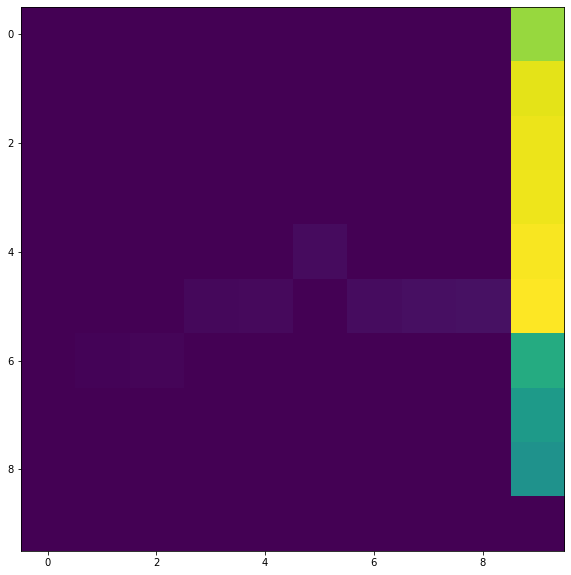

In [43]:
show_env(env,run_path)